In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import stats

In [3]:
vel1 = np.load('../velocities.npy')

In [4]:
vel1.shape

(327680, 2000, 3)

In [146]:
def compute_sf(vel, sf, device, dtype):
    
    taus = sf[0].astype(np.int64)
    
    vel = vel.astype(dtype)
    time_len = vel.shape[-2]
    
    #vel_ = torch.from_numpy(vel).to(device)
    vel_ = torch.from_numpy(vel).to(device)
    
    for tau_idx, tau in enumerate(taus):
        t_1 = torch.tensor(np.arange(tau, time_len))
        t_2 = torch.tensor(np.arange(0, time_len - tau))
        
        diff = vel_[:, t_1, 0] - vel_[:, t_2, 0]
        diff = torch.square(diff)
        
        sf[1,tau_idx] += torch.sum(diff).cpu()
        sf[2,tau_idx] += torch.sum(torch.square(diff)).cpu()
        sf[3,tau_idx] += torch.sum(torch.pow(diff, 3)).cpu()
        sf[4,tau_idx] += torch.sum(torch.pow(diff, 4)).cpu()
        sf[5,tau_idx] += torch.sum(torch.pow(diff, 5)).cpu()
        sf[6,tau_idx] += torch.sum(torch.pow(diff, 6)).cpu()

    return sf

def sf_wrap(
    vel,
    device            = torch.device('cuda'),
    dtype             = np.float64,
    chunk_size        = False,
):
    
    # DEFINE TAUS
    taus = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15,
        18, 22, 26, 31, 38, 46, 55, 66, 79,
        95, 114, 137, 164, 197, 237, 284,
        341, 410, 492, 590, 708, 850, 1020]
    
    # PREPARE SF ARRAY
    sf = np.zeros((7,len(taus)))
    sf[0] = taus

    # DO COMPUTATION ON GPU OR CPU (IN PARALLEL)    
    if chunk_size:
        
        n_chunks = vel.shape[0] // chunk_size
        chunks_idxs = []
        for ii in range(n_chunks):
            chunks_idxs.append(slice(ii*chunk_size, (ii+1)*chunk_size))
        
        if chunks_idxs[-1].stop < vel.shape[0]:
            print('adding last {} idxs'.format(vel.shape[0] % chunk_size))
            chunks_idxs[-1] = slice((n_chunks-1)*chunk_size, vel.shape[0]-1)

        for ii in range(n_chunks):
            vel_chunk = vel[chunks_idxs[ii]]
            sf[1:] = sf[1:] + compute_sf(vel_chunk, sf, device, dtype=dtype)[1:]
    else:
        sf = compute_sf(vel, sf, device, dtype=dtype)
    
    # NORMALIZE
    taus = sf[0].astype(np.int64)
    time_len = vel.shape[1]
    tau_idxs = np.arange(sf.shape[1])
    sf[1:,tau_idxs] = sf[1:,tau_idxs] / (( time_len - taus ) * vel.shape[0])
    
    return sf
    

In [80]:
# taus = [2**i for i in range(11)]
taus = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15,
        18, 22, 26, 31, 38, 46, 55, 66, 79,
        95, 114, 137, 164, 197, 237, 284,
        341, 410, 492, 590, 708, 850, 1020]

In [115]:
torch.cuda.empty_cache()

In [116]:
vel = vel1[:5000]
vel.shape

(5000, 2000, 3)

In [150]:
%time sf = sf_wrap(vel, dtype=np.float32, chunk_size=100)

CPU times: user 1.08 s, sys: 21.1 ms, total: 1.11 s
Wall time: 1.1 s


In [97]:
%time sf = sf_wrap(vel, dtype=np.float32)

CPU times: user 803 ms, sys: 413 ms, total: 1.22 s
Wall time: 1.21 s


In [99]:
device = torch.device('cpu')
%time sf = sf_wrap(vel, device, dtype=np.float32)

CPU times: user 3min 7s, sys: 25 s, total: 3min 32s
Wall time: 11.3 s


In [134]:
%time sf_old = stats.compute_sf(vel)

Database with more than one component. Only x taken
Taking entire dataset, None samples
Converting database to fortran order
(2000, 5000)
CPU times: user 3.67 s, sys: 40.8 ms, total: 3.71 s
Wall time: 3.67 s


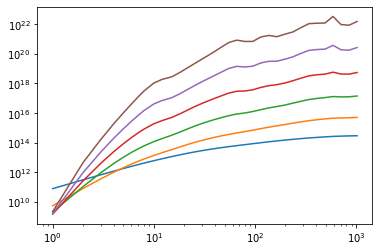

In [151]:
plt.plot(sf[0], sf[1])
plt.plot(sf[0], sf[2])
plt.plot(sf[0], sf[3])
plt.plot(sf[0], sf[4])
plt.plot(sf[0], sf[5])
plt.plot(sf[0], sf[6])
plt.xscale('log')
plt.yscale('log')
plt.show()

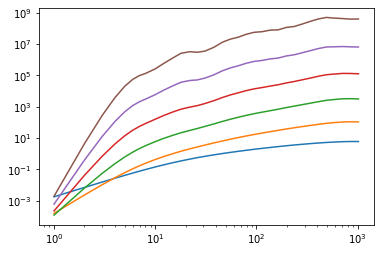

In [149]:
old = sf_old
plt.plot(old[:,0], old[:,1])
plt.plot(old[:,0], old[:,2])
plt.plot(old[:,0], old[:,3])
plt.plot(old[:,0], old[:,4])
plt.plot(old[:,0], old[:,5])
plt.plot(old[:,0], old[:,6])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [136]:
max_rel_error = np.max( np.abs( sf_old - sf.T ) / sf_old )
print(max_rel_error)

76200753490286.58
